In [16]:
# DCGAN : CNN을 GAN에 적용한 알고리즘 - 비지도학습
# MNIST dataset을 사용
# input -> Generator(생성자) -> fake data -> Descriminator가 판별 (원본과 구분할 수 없는 가짜 데이터가 생성될 때 까지 반복)
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ReLU, LeakyReLU, Conv2D, UpSampling2D
from keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [21]:
# Generator가 만드는 이미지 저장 폴더
if not os.path.exists("./gan_images"):
  os.makedirs("./gan_images")

# np.random.seed(3)
tf.random.set_seed(3)

# Generator model
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(alpha=0.2)))  # GAN은 ReLU 학습이 다소 불안정하기에 LeakyReLU을 사용한다.
generator.add(BatchNormalization())  # 배치정규화 진행 - 안정적 학습:과적합 방지 효과
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())  # 이미지 크기를 2배 확장
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.3)))  # alpha = 음의 기울기 계수 (-1 ~ 1 사이)
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
print(generator.summary())

# Descriminator model
descriminator = Sequential()
descriminator.add(Conv2D(64, kernel_size=5, padding='same',strides=2, input_shape=(28,28,1)))
descriminator.add(Activation(LeakyReLU(0.2)))
descriminator.add(Conv2D(128, kernel_size=5, padding='same'))
descriminator.add(Activation(LeakyReLU(0.2)))
descriminator.add(Flatten())
descriminator.add(Dropout(0.3))
descriminator.add(Dense(1, activation='sigmoid'))
print(descriminator.summary())

descriminator.compile(optimizer='adam', loss='binary_crossentropy')
descriminator.trainable=False  # 판별자 자신은 학습하면 안되기 때문에 학습기능 끄기


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_8 (Bat  (None, 6272)              25088     
 chNormalization)                                                
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_8 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_9 (Bat  (None, 14, 14, 64)       

In [22]:
# gan model
ginput = Input(shape=(100,))
dis_output = descriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')
print(gan.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_7 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_8 (Sequential)   (None, 1)                 231681    
                                                                 
Total params: 1096962 (4.18 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 244353 (954.50 KB)
_________________________________________________________________
None


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 27ms/step
epoch:1508  d_loss=0.4677  g_loss=2.2150
1/1 [==============================] - 0s 23ms/step
epoch:1509  d_loss=0.6236  g_loss=1.4611
1/1 [==============================] - 0s 24ms/step
epoch:1510  d_loss=0.4430  g_loss=1.6787
1/1 [==============================] - 0s 15ms/step
epoch:1511  d_loss=0.4863  g_loss=2.3440
1/1 [==============================] - 0s 15ms/step
epoch:1512  d_loss=0.2899  g_loss=3.3928
1/1 [==============================] - 0s 19ms/step
epoch:1513  d_loss=0.4796  g_loss=3.2054
1/1 [==============================] - 0s 16ms/step
epoch:1514  d_loss=0.5820  g_loss=1.8855
1/1 [==============================] - 0s 15ms/step
epoch:1515  d_loss=0.3120  g_loss=1.8248
1/1 [==============================] - 0s 16ms/step
epoch:1516  d_loss=0.3973  g_loss=2.0938
1/1 [==============================] - 0s 15ms/step
epoch:1517  d_loss=0.2225  g_loss=2.8566
1/1 [=============================

<ipython-input-24-860a15561398>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)


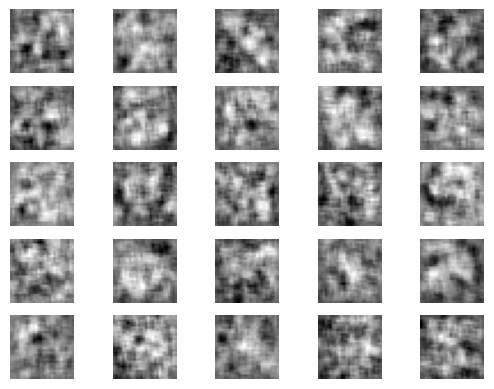

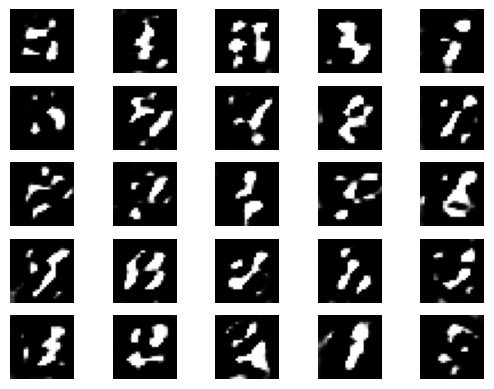

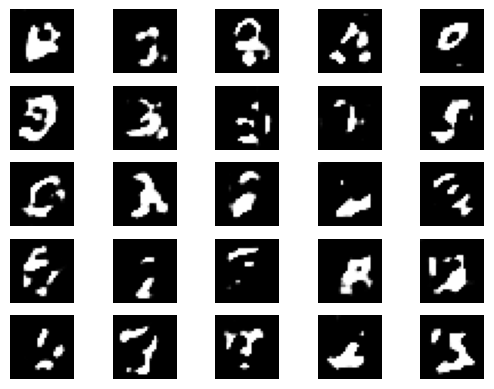

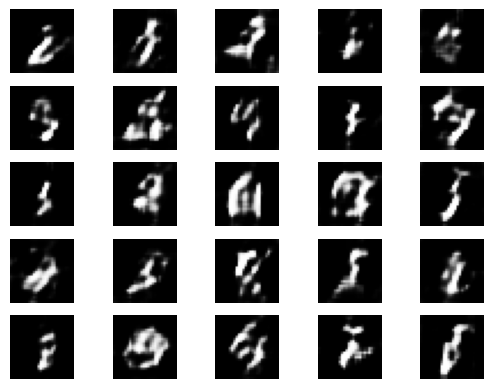

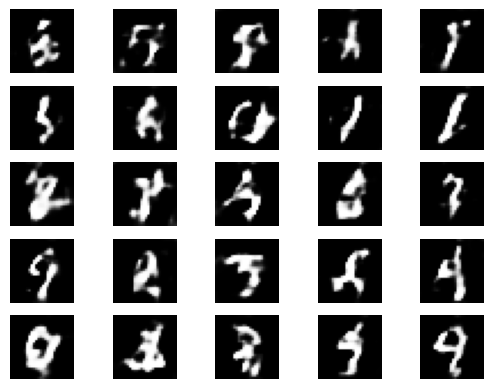

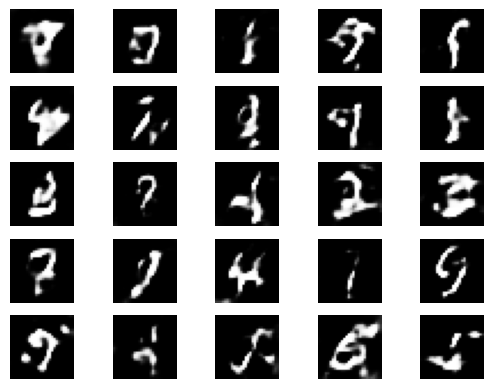

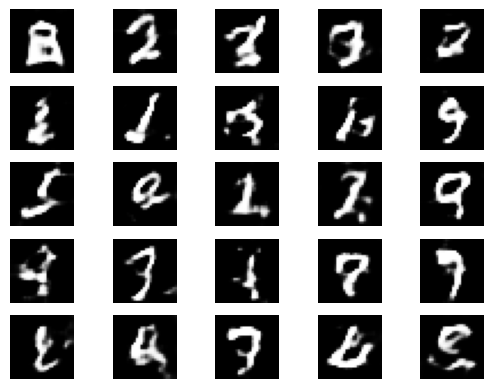

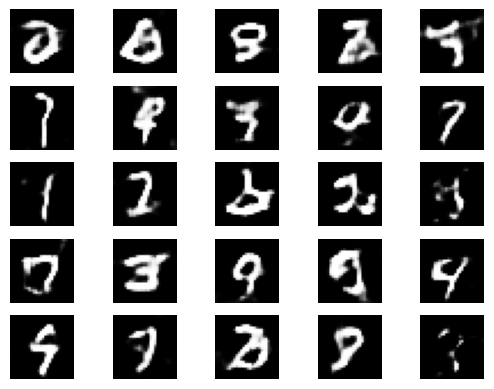

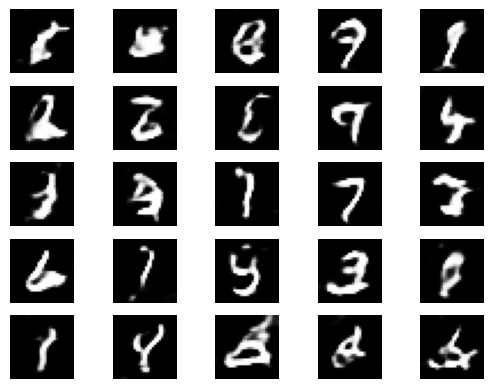

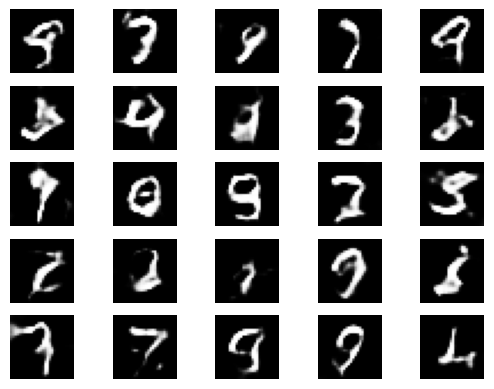

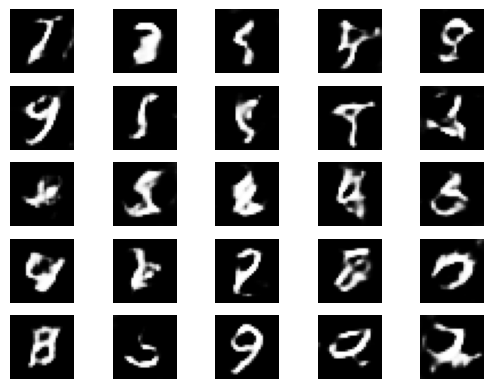

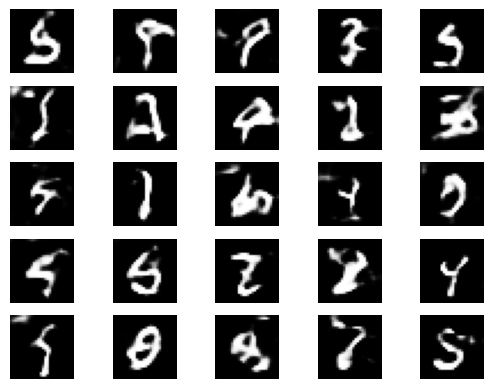

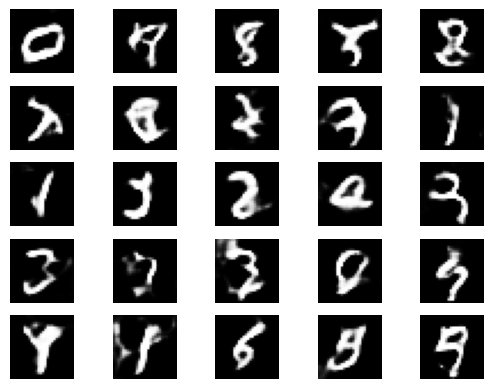

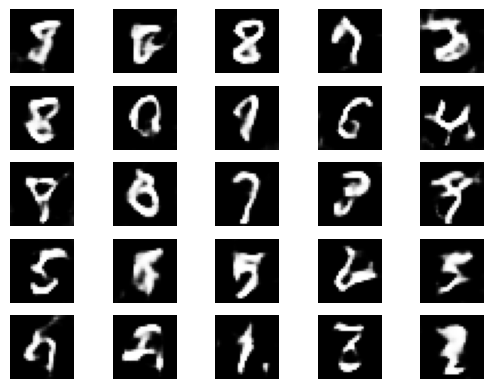

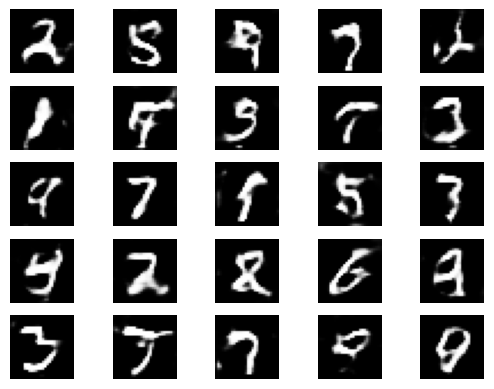

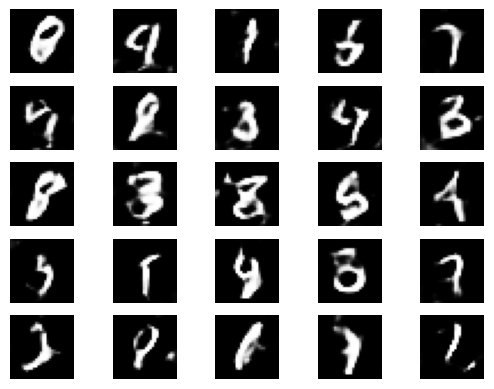

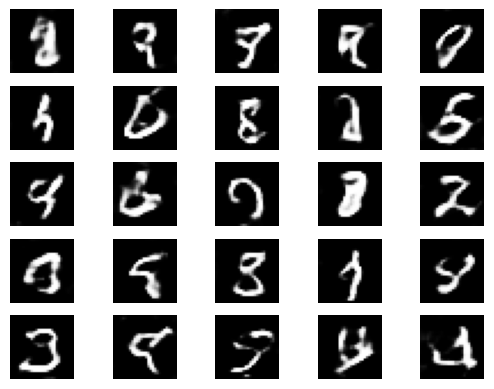

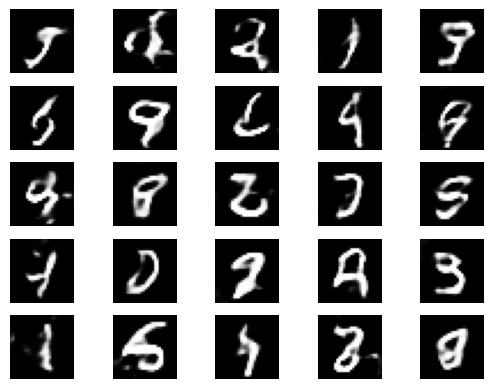

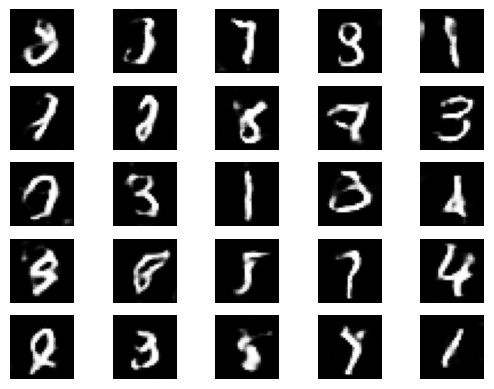

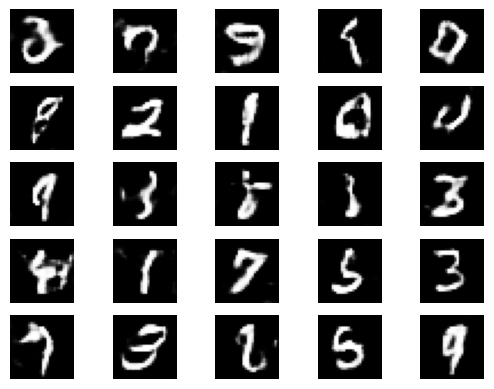

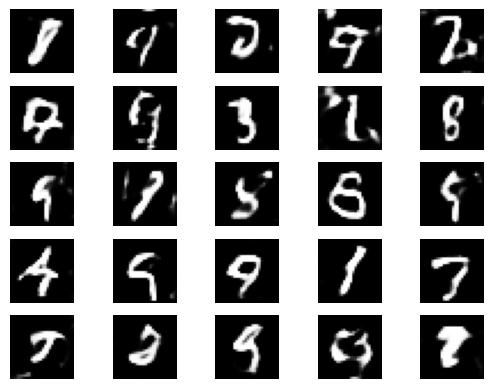

In [24]:
# 신경망 실행 함수
def gan_train(epoch, batch_size, saving_interval):
  (x_train, _),(x_test, _) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
  x_train = (x_train - 127.5) / 127.5  # -1 ~ 1사이 값으로 바뀜

  true = np.ones((batch_size, 1))
  # batch_size는 한 번에 몇개의 실제 이미지와 가짜이미지를 판별자에 넣을지 결정
  # 먼저 batch_size 만큼 mnist이미지를 랜덤하게 불러와 판별자에 집어 넣는 과정이다. 실제 이미지를 입력했으므로 모두 참(1)

  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, x_train.shape[0], batch_size)  # 실제 이미지를 랜덤하게 선택해 판별자에 입력
    imgs = x_train[idx]

    d_loss_real = descriminator.train_on_batch(imgs, true)  # batch_size만큼 판별시작

    # 가상 이미지를 판별자에 입력하기
    noise = np.random.normal(0,1,(batch_size, 100))  # 잠재공간에서 무작위로 샘플링
    gen_imgs = generator.predict(noise)
    d_loss_fake = descriminator.train_on_batch(gen_imgs, fake)  # gen_imgs에 모두 가짜(0)라는 레이블이 붙음

    # 판별자와 생산자의 오차를 계산
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5
    g_loss = gan.train_on_batch(noise, true)  # 판별자와 생성자를 연결해서 만든 gan모델을 이용해 생성자의 오차(g_loss)를 구함
    print('epoch:%d'%i, ' d_loss=%.4f'%d_loss, ' g_loss=%.4f'%g_loss)  # 생성자와 파별자의 오차출력

    if i % saving_interval ==0:
      noise = np.random.normal(0,1,(25, 100))  # 잠재공간에서 무작위로 샘플링
      gen_imgs = generator.predict(noise)
      gen_imgs = gen_imgs * 0.5 + 0.5  # rescale : 0 ~ 1

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig('gan_images/gmnist_%d.png'%i)

gan_train(4001, 32, 200)